<h1>RFM-анализ интернет магазина</h1>

<h4>Скачайте датасет и проведите RFM анализ.<br>
    В каждом подсегменте поделите пользователей на 4 класса (как на занятии).<br>
    Отсчитывайте количество дней, прошедших с момента последней покупки, 
    с максимальной даты покупки в датасете.</h4>

<ol>
   
<li>Какое максимальное кол-во покупок было совершено одним пользователем?</li>
<li>Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М? ).<br>(Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс в подсегменте М)</li>
<li>Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?</li>
<li>Какая верхняя граница у количества покупок у пользователей с классом 2 в подсегменте R?</li>
<li>Сколько пользователей попало в сегмент 111?</li>
<li>Сколько пользователей попало в сегмент 311?</li>
<li>В каком RFM-сегменте самое большое кол-во пользователей?</li>
<li>В каком RFM-сегменте самое маленькое кол-во пользователей?</li>
<li>Какое количество пользователей попало в самый малочисленный сегмент?</li></ol>

### БИБЛИОТЕКИ

In [236]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import datetime
from datetime import timedelta
from datetime import datetime
import time

### ЗАГРУЗКА ДАННЫХ

In [80]:
#Чтобы узнать текущую дирректорию
os.getcwd()
# Чтобы узнать что лежит в текущей дирректории
os.listdir()
# - ~/ - относительный путь
# - ../ - путь с поднятием вверх из другой папки до корневой
# (подъём на уровень выше - домашняя директория ~)

# Запишем путь файла в переменную
path_df = "~/Product_Analytics/Lesson_4/RFM_ht_data.csv"
# Cчитаем DF c помощью лямбда-функции
download_df = lambda x:  pd.read_csv(x, sep=',', parse_dates=['InvoiceDate']) #парсим дату
# Присвоим переменную датафрейму
df = download_df(path_df)
df

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,InvoiceNo,CustomerCode,InvoiceDate,Amount
0,C0011810010001,19067290,2020-09-01,1716.00
1,C0011810010017,13233933,2020-09-01,1489.74
2,C0011810010020,99057968,2020-09-01,151.47
3,C0011810010021,80007276,2020-09-01,146.72
4,C0011810010024,13164076,2020-09-01,104.00
...,...,...,...,...
332725,S0081810310459,14092500,2020-09-30,3801.87
332726,S0081810310461,99065678,2020-09-30,5769.88
332727,S0081810310462,19029918,2020-09-30,736.88
332728,S0081810310463,13020033,2020-09-30,1475.20


### ПРОВЕРКА ДАННЫХ

In [81]:
# Проверим размер DF
print("Размер исходного датафрейма:\n{}".format(df.shape), "\n")

# Преобразуем колонки с датой
#df_ecomm["date"] = pd.to_datetime(df_ecomm["date"])

# Преобразуем колонки со смешанным типом данных
# Расчёты мб неправильными (Предупреждение при загрузке DF)
df.InvoiceNo = df.InvoiceNo.apply(str)
df.CustomerCode = df.CustomerCode.astype("str")

# Проверим типы данных столбцов DF
print("Форматы колонок тисходного датафрейма:\n{}".format(df.dtypes), '\n')

# Проверим DF на пропуски
print("Число пропусков в колонках исходного датафрейма:\n{}".format(df.isna().sum()), '\n')

Размер исходного датафрейма:
(332730, 4) 

Форматы колонок тисходного датафрейма:
InvoiceNo               object
CustomerCode            object
InvoiceDate     datetime64[ns]
Amount                 float64
dtype: object 

Число пропусков в колонках исходного датафрейма:
InvoiceNo       0
CustomerCode    0
InvoiceDate     0
Amount          0
dtype: int64 



<h3>Произведем RFM-анализ</h3>

In [82]:
"""
Будем отсчитывайть количество дней, прошедших с момента последней покупки,
с максимальной даты покупки в датасете  до сегодняшнего дня.
"""



# Опеределим cамую последнюю дату покупки в DF
last_date = df['InvoiceDate'].max()

# Преобразуем str формат переменной now в формат datetime64
#last_date = datetime.strptime(last_date, '%Y-%m-%d')

print("Самая последная дата покупки в DF: {}.\n\
От нее и будем считать параметр 'Recency'.".format(last_date.strftime("%Y-%m-%d")))

Самая последная дата покупки в DF: 2020-09-30.
От нее и будем считать параметр 'Recency'.


<h5>Выделим RFM метрики</h5>

In [93]:
# Создадим новые колонки с:
# Recency - числом дней с момента поледней покупки пользователя
# Frequency - суммарное количество покупок у пользователя за всё время
# Monetary - сумма покупок у пользователя за всё время

df_rfm = df\
                    .groupby('CustomerCode', as_index=False)\
                    .agg({'InvoiceDate': lambda x: (last_date - x.max()).days, 
                          'InvoiceNo': lambda x: len(x),     
                          'Amount': lambda x: x.sum()})

df_rfm = df_rfm.rename(columns={
                                'InvoiceDate':'Recency',
                                'InvoiceNo':'Frequency',
                                'Amount':'Monetary'
                                })
df_rfm

,CustomerCode,Recency,Frequency,Monetary
0,02213019,19,1,1609.20
1,02213042,22,3,9685.48
2,02213071,29,1,415.00
3,02213088,23,1,305.00
4,02213092,25,1,1412.88
...,...,...,...,...
123728,99099927,10,1,961.10
123729,99099936,0,1,1521.78
123730,99099959,8,2,1444.56
123731,99099963,19,1,3018.91


<h5>Разделим пользователей на 4 равных группы (т.е. каждую метрику)</h5> 

In [97]:
# Определим границы квантилей
# Поделим на равные части
list_borders = [0.25, 0.5, 0.75]

# Создадим DF с границами групп по каждой метрике
quantiles = df_rfm.quantile(q=list_borders, interpolation="higher")
quantiles

,Recency,Frequency,Monetary
0.25,2,1,765.00
0.50,8,2,1834.48
0.75,16,3,4008.84


In [98]:
# Выделен новую переменную для DF, чтобы не потерять предыдущий DF (без RFM анализа)
df_rfmSegmentation = df_rfm

In [108]:
quantiles.Frequency[0.5]

2

<h5>Опишем ф-и для присвоения рангов</h5> 

In [135]:
# Ф-я для кол-ва дней с последней покупки
# Чем больше дней, тем меньше ранг
def RClass(value,parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 1
    elif value <= quantiles_table[parameter_name][0.50]:
        return 2
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 3
    else:
        return 4

# Ф-я для общей суммы и для числа покупок 
# Чем больше сумма, тем больше и ранг
def FMClass(value, parameter_name,quantiles_table):
    if value <= quantiles_table[parameter_name][0.25]:
        return 4
    elif value <= quantiles_table[parameter_name][0.50]:
        return 3
    elif value <= quantiles_table[parameter_name][0.75]: 
        return 2
    else: 
        return 1

In [136]:
# Вызовем фу-ю разными способами

# Recency
df_rfmSegmentation['R_Quartile'] = df_rfmSegmentation['Recency'].apply(lambda x: RClass(x,'Recency',quantiles))

# Frequency
df_rfmSegmentation['F_Quartile'] = df_rfmSegmentation['Frequency'].apply(FMClass, args=('Frequency',quantiles))

# Monetary
df_rfmSegmentation['M_Quartile'] = df_rfmSegmentation['Monetary'].apply(FMClass, args=('Monetary',quantiles))

In [137]:
df_rfmSegmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123733 entries, 0 to 123732
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CustomerCode  123733 non-null  object 
 1   Recency       123733 non-null  int64  
 2   Frequency     123733 non-null  int64  
 3   Monetary      123733 non-null  float64
 4   R_Quartile    123733 non-null  int64  
 5   F_Quartile    123733 non-null  int64  
 6   M_Quartile    123733 non-null  int64  
 7   RFMClass      123733 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 8.5+ MB


In [138]:
# Найдём RFM. Но так как квартили формамата int64, то нужно в расчётах преобразовать каждый квартиль
#  в str формат и сложить эти строки

# Для этого используем функцию map()
df_rfmSegmentation['RFMClass'] = df_rfmSegmentation.R_Quartile.map(str) \
                                                                    + df_rfmSegmentation.F_Quartile.map(str)\
                                                                    + df_rfmSegmentation.M_Quartile.map(str)
df_rfmSegmentation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123733 entries, 0 to 123732
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   CustomerCode  123733 non-null  object 
 1   Recency       123733 non-null  int64  
 2   Frequency     123733 non-null  int64  
 3   Monetary      123733 non-null  float64
 4   R_Quartile    123733 non-null  int64  
 5   F_Quartile    123733 non-null  int64  
 6   M_Quartile    123733 non-null  int64  
 7   RFMClass      123733 non-null  object 
dtypes: float64(1), int64(5), object(2)
memory usage: 8.5+ MB


In [139]:
df_rfmSegmentation['RFMClass'] = df_rfmSegmentation['RFMClass'].map(int)
df_rfmSegmentation.dtypes

CustomerCode     object
Recency           int64
Frequency         int64
Monetary        float64
R_Quartile        int64
F_Quartile        int64
M_Quartile        int64
RFMClass          int64
dtype: object

In [140]:
df_rfmSegmentation.query("F_Quartile == 1")

,CustomerCode,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMClass
6,02213129,1,4,2199.00,1,1,2,112
13,02213280,0,6,4772.93,1,1,1,111
18,02213315,0,4,13386.21,1,1,1,111
22,02213383,2,8,6283.81,1,1,1,111
28,02213478,0,4,6270.09,1,1,1,111
...,...,...,...,...,...,...,...,...
123719,99099814,1,11,9610.69,1,1,1,111
123720,99099847,16,4,8139.48,3,1,1,311
123724,99099889,0,8,6874.10,1,1,1,111
123725,99099890,4,10,16090.53,2,1,1,211


In [241]:
pd.crosstab(index = df_rfmSegmentation.R_Quartile, columns = df_rfmSegmentation.F_Quartile)

F_Quartile,1,2,3,4
R_Quartile,,,,
1,14433,4671,5795,6074
2,9634,5889,8633,10399
3,3091,3748,7734,13263
4,542,1311,5415,23101


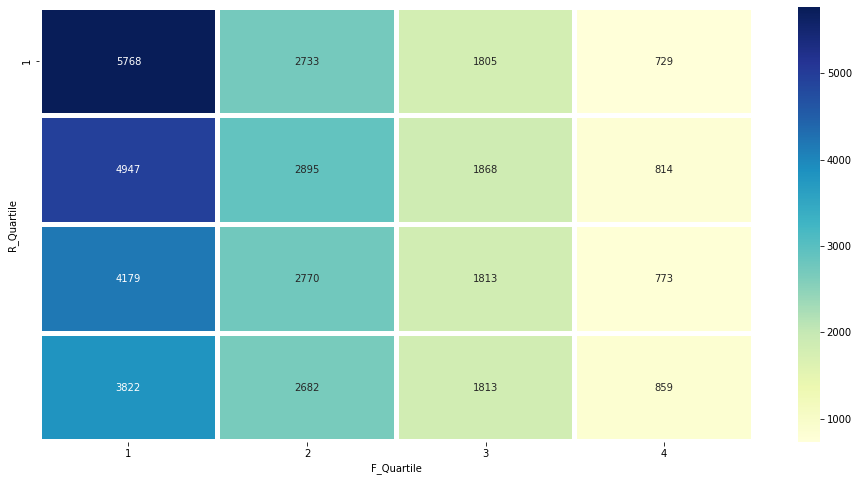

In [246]:
plt.figure(figsize=(16, 8))

rfm_table = df_rfmSegmentation.pivot_table(
                        index='R_Quartile', 
                        columns='F_Quartile', 
                        values='Monetary', 
                        aggfunc=np.median).applymap(int)
sns.heatmap(rfm_table, cmap="YlGnBu", annot=True, fmt=".0f", linewidths=4.15, annot_kws={"size": 10},yticklabels=4);

### *1. Какое максимальное кол-во покупок было совершено одним пользователем?*

In [178]:
df_rfm.Frequency.max()

204

### *2. Какая верхняя граница у суммы покупок у пользователей с классом 4 в подсегменте М?<br> (Другими словами: пользователи, у которых сумма покупок от 0 до Х попадают в 4 класс <br>в подсегменте М)*

In [184]:
quantiles.Monetary[0.25]

765.0

### *3. Какая нижняя граница у количества покупок у пользователей с классом 1 в подсегменте F?*

In [187]:
quantiles.Frequency[0.75]+1

4

### *4. Какое максимальное количество дней может пройти с момента последней покупки для того, чтобы пользователь попал в класс 2 в подсегменте R?*

In [189]:
quantiles.Recency[0.5]

8

### *5. Сколько пользователей попало в сегмент 111?*

In [194]:
df_rfmSegmentation.query("RFMClass == 111").shape[0]

9705

### *6. Сколько пользователей попало в сегмент 311?*

In [195]:
df_rfmSegmentation.query("RFMClass == 311").shape[0]

1609

### *7. В каком RFM-сегменте самое большое кол-во пользователей?*

In [200]:
df_rfmSegmentation.groupby("RFMClass", as_index=False).agg({"CustomerCode":"count"}).max().RFMClass          

444

### *8. В каком RFM-сегменте самое маленькое кол-во пользователей?*

In [227]:
df_rfmSegmentation.groupby("RFMClass", as_index=False).agg({"CustomerCode":"count"}).sort_values("CustomerCode").head(1).RFMClass[51]

414

### *9. Какое количество пользователей попало в самый малочисленный сегмент?*

In [205]:
df_rfmSegmentation.RFMClass.value_counts().min()

2